# Analysis of the Gnutella Network

{INSERT GEPHI PICTURE HERE}

Gnutella was a p2p file sharing network from the early 2000's.
Nodes were computers (often consumer desktops and laptops)
and edges where connections between these.

The following presents an analysis of the network as 9 different points in time.
Due to the size of the data set, we have divided our anlysis into two parts:
1. Computation and saving of various network properties into .json files.
2. Plotting and analysing network properties from the .json files.

The intention of our analyis is to answer the following:
<i>How robust is the Gnutella network?</i>

## Table of Contents
- Imports
- Reading the data
- Data Schema
- Constructing the json files
    - Centrality
    - Attack
    - Metrics
    - Execution
- Analysis
    - Degree Distribution
    - Centraliy Measures
        - Closeness
        - Betweenness
    - Fitting
    - Robustness
- Conclusion
- Appendix

## imports
Throughout this analysis we use the following libraries:

In [50]:
# imports
import networkx as nx
import random
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import powerlaw
from collections import Counter
import os
import numpy as np

## Reading the Data

We construct a dictionary `S`  of the 9 networkx objects for use throughout the notebook.

In [12]:
path = '../data/graphs/'
targets = [path + target for target in os.listdir(path)]
S = {idx: nx.read_edgelist(target, delimiter="\t", create_using=nx.DiGraph(name='test')) \
     for idx, target in enumerate(targets)}
for idx, G in enumerate(S):
    S[G].name = targets[idx][-6:-4] + '-08-2002'

## Data Scheme

Each generated .json file has the following structure:
- Original graph networkx output
- Configuration model networkx outputs

## Constructing the .json Files

The construction of the data files was done by the use of four classes:
1. Centrality: Computes centrality measure for a given graph
2. Attack: Computes the effect of removing nodes for a given graph
3. Metrics: Computes various other graph properties and creates the .json file

The classes and the code execution for generating the .json is provided below.

### Centrality

The centrality to class takes in a graph and outputs a dictionary of arrays of
various centrality measures. These measures are:

- Betweenness centrality
- Wigenvector centrality
- Closeness centrality
- Indegree centraility
- Outdegree centrality

The code is as follows

In [13]:
class Centrality(object):

    def __init__(self, G):
        self.G = G
        self.data = {}

    def extract(self):
        self.__setup(self.G)
        return self.data

    def __setup(self, G):
        if G.is_multigraph():
            G = nx.DiGraph(G)
        self.data['betweenness'] = self.__centrality(nx.betweenness_centrality(G, k=1000))
        self.data['eigenvector'] = self.__centrality(nx.eigenvector_centrality(G, max_iter=200))
        self.data['in_degree'] = self.__centrality(nx.in_degree_centrality(G))
        self.data['out_degree'] = self.__centrality(nx.out_degree_centrality(G))
        self.data['closeness'] = self.__closeness(G)

    def __centrality(self, data):
        w = np.ones_like(list(data.values())) / (len(data.values()))
        n, x, _ = plt.hist(list(data.values()), bins=20, weights=w)
        plt.close()
        bin_centers = 0.5*(x[1:]+x[:-1])
        return list(bin_centers), list(n)

    def __closeness(self, G):
        data = {}
        L = self.__component(G)
        for node in random.sample(L.nodes(), 1000):
            data[node] = nx.closeness_centrality(L, u=node)
        x, y = self.__centrality(data)
        return list(x), list(y), data

    def __component(self, G):
        components = sorted(nx.strongly_connected_components(G), key=len)[::-1]
        L = G.subgraph(components[0])
        return L

def centrality(G):
    C = Centrality(G).extract()
    return C

### Robustness

Central to our research question,
the robust class is used to test how the network responds to
removing nodes in the following ways:

- Randomly
- By degree
- By eigenvector centrality
- By some other bull shit.

We considered removing edges, however, it perhaps does not make much conceptual sense
for our network, as a computer is either online or not, and not partially online.

In [14]:
class Attack(object):

    def __init__(self, graph):
        self.graph = graph
        self.L = self.__component(self.graph)

    def random(self, p):
        G = self.L
        nodes = random.sample(G.nodes, int(float(len(G.nodes)) * (1-p)))
        S = nx.subgraph(G, nodes)
        return S

    def degrees(self, p):
        G = self.L
        degs = sorted(G.degree, key=itemgetter(1))[::-1]
        nodes = [entry[0] for entry in degs][int(len(degs) * p):]
        S = nx.subgraph(G, nodes)
        return S

    def eigen(self, p):
        G = self.L
        if G.is_multigraph():
            G = nx.DiGraph(G)
        eiges = nx.eigenvector_centrality(G, max_iter=200)
        nodes = [(k, v) for k, v in eiges.items()]
        nodes = sorted(nodes, key=itemgetter(1))[::-1]
        nodes = [entry[0] for entry in nodes][int(len(nodes) * p):]
        S = nx.subgraph(G, nodes)
        return S

    def pagerank(self, p):
        G = self.L
        if G.is_multigraph():
            G = nx.DiGraph(G)
        eiges = nx.pagerank(G)
        nodes = [(k, v) for k, v in eiges.items()]
        nodes = sorted(nodes, key=itemgetter(1))[::-1]
        nodes = [entry[0] for entry in nodes][int(len(nodes) * p):]
        S = nx.subgraph(G, nodes)
        return S

    def __component(self, G):
        components = sorted(nx.strongly_connected_components(G), key=len)[::-1]
        L = G.subgraph(components[0])
        return L

### Metrics

Putting together the results of running the previous two classes on each og our 9
graphs and their corresponding configuration models, while also adding various other
data like degree distributions, etc. In other words, this class constructs the .json file.


In [15]:
class Metric:

    def __init__(self, G, data={}):
        self.G = G
        self.U = nx.Graph(G)
        self.name = G.name
        self.data = data

    def build(self):
        self.__setup(self.G)

    def save(self):
        json_data = json.dumps(self.data, indent=4)
        with open(f'../data/dumps/{self.name}.json', 'w') as json_file:
            json_file.write(json_data)

    def __setup(self, G):
        G_degs = self.__degfreq(G)         # degree distribution
        self.data['degs'] = {'in': G_degs[0], 'out': G_degs[1],
                             'ccdf_in': G_degs[2], 'ccdf_out': G_degs[3]}
        self.data['centrality'] = centrality(G)         # centrality measures, clustering, knn
        self.data['clustering'] = self.__clustering(G)
        knn = nx.k_nearest_neighbors(G)
        self.data['knn'] = [list(knn.keys()), list(knn.values())]
        self.data['attack'] = self.__attack(G)         # attacks
        C = self.__config(G)         # configuration metrics
        knn = nx.k_nearest_neighbors(C)
        self.data['C'] = {'attack': self.__attack(C), 'centrality': centrality(C),
                          'clustering': self.__clustering(C),
                          'knn': [list(knn.keys()), list(knn.values())]}

    def __attack(self, G):
        A = Attack(G)
        ps = [0.05 * i for i in range(0, 20)]
        rs, ds, es, pr = [], [], [], []
        for p in ps:
            r = A.random(p)
            d = A.degrees(p)
            e = A.eigen(p)
            pa = A.pagerank(p)
            rs.append(self.__connectivity(r))
            ds.append(self.__connectivity(d))
            es.append(self.__connectivity(e))
            pr.append(self.__connectivity(pa))
        return rs, ds, es, pr, ps

    def __degfreq(self, G):
        in_freq = Counter(dict(G.in_degree).values())
        in_x = list(in_freq.keys())
        in_y = list(in_freq.values())
        out_freq = Counter(dict(G.out_degree).values())
        out_x = list(out_freq.keys())
        out_y = list(out_freq.values())
        ins = list(dict(G.in_degree).values())      # ccdf setup
        outs = list(dict(G.out_degree).values())    # ccdf setup
        in_ccdf_x, in_ccdf_y = self.__ccdf(ins)
        out_ccdf_x, out_ccdf_y = self.__ccdf(outs)
        return [in_x, in_y], [out_x, out_y], [in_ccdf_x, in_ccdf_y], [out_ccdf_x, out_ccdf_y]

    def __ccdf(self, degs):
        n, x, _ = plt.hist(degs, density=True, cumulative=True, bins=100); plt.close()
        x = 0.5 * (x[1:] + x[:-1])
        y = [1 - v for v in n]
        return [list(x), list(y)]

    def __clustering(self, G):
        if G.is_multigraph():
            G = nx.DiGraph(G)
        cluster = Counter(dict(nx.clustering(G)).values())
        x = list(cluster.keys())
        y = list(cluster.values())
        return x, y

    def __config(self, G):
        d_in = [G.in_degree[node] for node in G.nodes]
        d_out = [G.out_degree[node] for node in G.nodes]
        return nx.directed_configuration_model(d_in, d_out)

    def __connectivity(self, G):
        L = self.__component(G)
        return len(L.nodes) / len(G.nodes)

    def __component(self, G):
        components = sorted(nx.strongly_connected_components(G), key=len)[::-1]
        L = G.subgraph(components[0])
        return L


### Execution

Setting construct to true in the following block will have the script generate the .json files.
However, as this takes a long itme, we have included the files from previous computations.

In [30]:
compute_json = False

def construct():                   # recompute json and pollute climate
    for G in tqdm(S.values()):
        D = Metric(G)
        D.build()
        D.save()
        
def use_json():                    # use precomputed json and save-ish the planet
    D = {}
    dumps = [f"../data/dumps/{target}" for target in sorted(os.listdir('../data/dumps/'))]
    for i in tqdm(range(len(dumps))):
        with open(dumps[i], 'r') as data_file:
            name = dumps[i].split('/')[-1].split('.')[0]
            data = json.load(data_file)
            D[i] = data
    return D

if compute_json:
    construct()
else:
    D = use_json()

100%|██████████| 9/9 [00:00<00:00, 56.72it/s]


## Analysis

We now proceede to show the following:
1. Degree distribution
2. Centrality measures
3. Fitting plot
4. Attack plot
5. Virus spreading

### Degree distribution

We plot the degree distribution of each graph

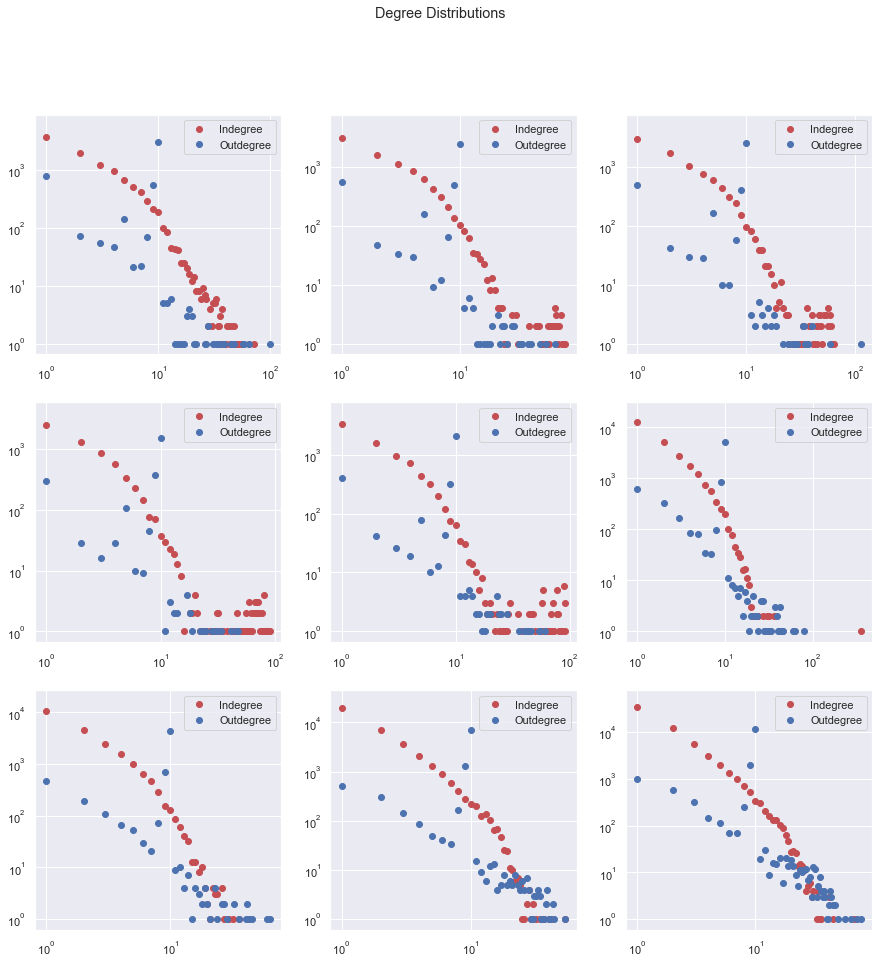

In [57]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for ax in axes:
    for ay in ax:
        indeg = D[i]['degs']['in']
        outdeg = D[i]['degs']['out']
        ay.loglog(indeg[0], indeg[1], 'ro', label='Indegree')
        ay.loglog(outdeg[0], outdeg[1], 'bo', label='Outdegree')
        ay.legend()
        i += 1

plt.suptitle('Degree Distributions')
plt.show()

Blah blah blah blah blah blah

### Centrality Measuress

At the time of crawling the network, two gnutella protocols were in fact in place (0.4 and 0.6)
0.4 used query flooding and 0.6 used query routing. It is in unlcear to us what protocol
was running on the nodes in our network. We have thus plotted the centrality
measure that was relevant in either case.

#### Betweenness centrality
blah blah blach

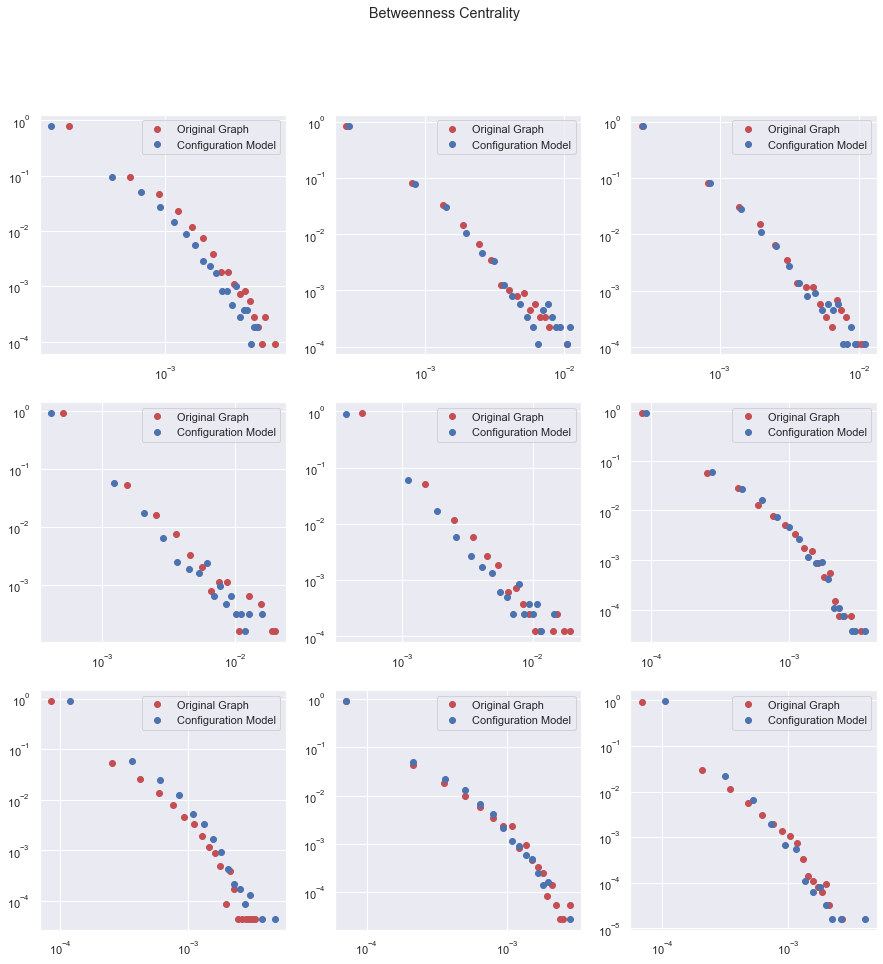

In [58]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for ax in axes:
    for ay in ax:
        orignal = D[i]['centrality']['betweenness']
        config = D[i]['C']['centrality']['betweenness']
        ay.loglog(orignal[0], orignal[1], 'ro', label='Original Graph')
        ay.loglog(config[0], config[1], 'bo', label='Configuration Model')
        ay.legend()
        i += 1

plt.suptitle('Betweenness Centrality')
plt.show()

#### Closeness centrality
To the extent that the network is using query flooding to find files, closeness centrality is essential.
Therefor we have plotted it here.

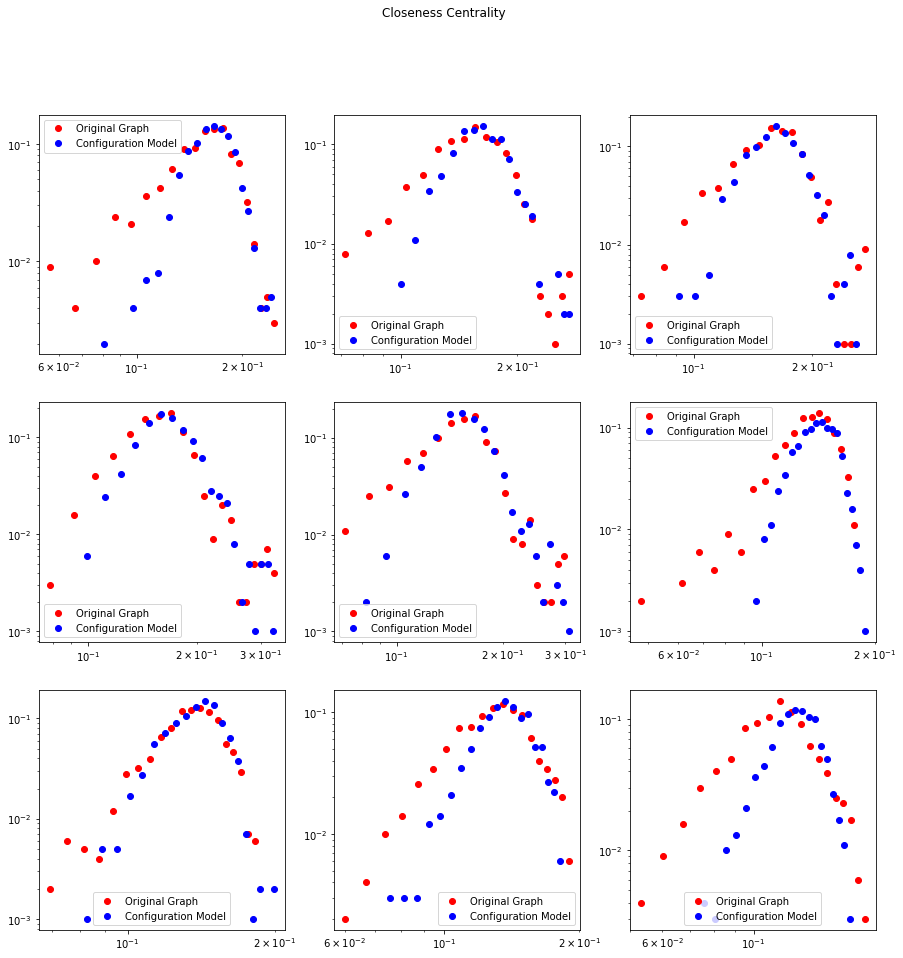

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for ax in axes:
    for ay in ax:
        orignal = D[i]['centrality']['closeness']
        config = D[i]['C']['centrality']['closeness']
        ay.loglog(orignal[0], orignal[1], 'ro', label='Original Graph')
        ay.loglog(config[0], config[1], 'bo', label='Configuration Model')
        ay.legend()
        i += 1

plt.suptitle('Closeness Centrality')
plt.show()

### Fitting

We do some fitting yeah.

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for ax in axes:
    for ay in ax:
        _, y = D['degs']['in']
        y = np.array(y); mask = y >= 3
        fit = powerlaw.Fit(y[mask], verbose=False)
        fig = fit.plot_ccdf(label='CCDF', color='r', linestyle='--', marker='o')
        fit.lognormal.plot_ccdf(ax=ay, color='c', linestyle='--', label='log-normal fit')
        fit.power_law.plot_ccdf(ax=ay, color='g', linestyle='--', label='power-law fit')
        fit.exponential.plot_ccdf(ax=ay, color='b', linestyle='--', label='exponential fit')
        fit.truncated_power_law.plot_ccdf(ax=ay, color='k', linestyle='--', label='truncated power law fit')
        plt.legend(); plt.title(f"{self.name} fit"); plt.ylabel(r"$P(k>=x)$"); plt.xlabel(r'$x$')
        plt.savefig(f'../plots/{self.name}/fitting-{self.name}.png', dpi=300); plt.close()


Thoughts about the fitting

### Robustness

Cursory research on the Gnutella network describes it as inefficient and problematic
Robustness is thus intersting

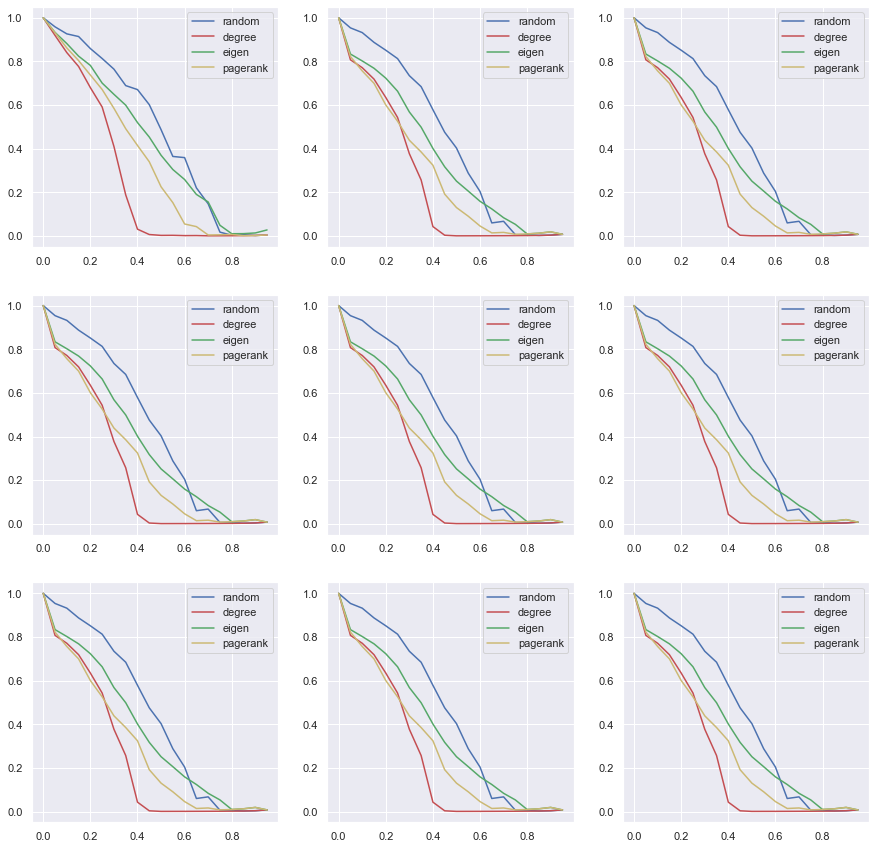

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for ax in axes:
    for ay in ax:
        kinds = ['random', 'degree', 'eigen', 'pagerank']; colors = 'brgy'
        G = D[i]['attack']
        #C = D[i]['C']['attack']
        for i in range(len(G) - 1):
            exec(f"ay.plot(G[-1], G[i], colors[i], label='{kinds[i]}')")
            # exec(f"plt.plot(C[-1], C[i], colors[i], linestyle='--', label='conf. {kinds[i]}')")
        #ay.xlabel('fraction attacked'); plt.ylabel('frac. of nodes in largest comp.')
        ay.legend()
        i += 1
plt.show()